In [1]:
	
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
pip install scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
random_seed=51
batch_size=512
epochs=50

learning_rate=1e-4
num_classes=10
patch_size=4
img_size=28
in_channels=1
num_heads=8
dropout=0.001
hidden_dim=768
adam_weight_decay=0
adam_betas=(0.9,0.999)
activation="gelu"
num_encoders=4
embed_dim=(patch_size ** 2)*in_channels
num_patches=(img_size//patch_size)**2


random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark= False

device='cuda' if torch.cuda.is_available() else 'cpu'




In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(embed_dim, patch_size, num_patches, dropout,in_channels).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import numpy as np

# ----------------------------------------------------------------
# Patch Embedding: Splits image into patches, adds class token & positional embeddings
# ----------------------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=embed_dim,
                      kernel_size=patch_size,
                      stride=patch_size),
            nn.Flatten(2)  # Flatten height and width into one dimension
        )
        # Learnable class token (shape: [1, 1, embed_dim])
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Positional embeddings for (num_patches + 1) tokens
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x: (B, in_channels, H, W)
        B = x.shape[0]
        x = self.patcher(x)         # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)         # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat([cls_tokens, x], dim=1)          # (B, num_patches+1, embed_dim)
        x = x + self.position_embeddings             # Add positional embeddings
        x = self.dropout(x)
        return x

# ----------------------------------------------------------------
# Custom Transformer Encoder Components
# ----------------------------------------------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h, dropout):
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model must be divisible by h"
        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    @staticmethod
    def attention(query, key, value, mask, dropout):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = dropout(attn)
        output = torch.matmul(attn, value)
        return output, attn

    def forward(self, q, k, v, mask=None):
        # q, k, v: (B, seq_len, d_model)
        B, seq_len, _ = q.size()
        # Linear projections
        query = self.w_q(q)  # (B, seq_len, d_model)
        key = self.w_k(k)
        value = self.w_v(v)
        # Reshape to (B, h, seq_len, d_k)
        query = query.view(B, seq_len, self.h, self.d_k).transpose(1,2)
        key = key.view(B, seq_len, self.h, self.d_k).transpose(1,2)
        value = value.view(B, seq_len, self.h, self.d_k).transpose(1,2)
        # Scaled dot-product attention
        x, attn = self.attention(query, key, value, mask, self.dropout)
        # Reshape back to (B, seq_len, d_model)
        x = x.transpose(1,2).contiguous().view(B, seq_len, self.d_model)
        return self.w_o(x)

class FeedForwardBlock(nn.Module):
    def __init__(self, d_model, d_ff, dropout, activation="gelu"):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        if activation.lower() == "gelu":
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, h, dropout)
        self.feed_forward = FeedForwardBlock(d_model, d_ff, dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention sublayer with residual connection
        x = x + self.dropout(self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask))
        # Feed-forward sublayer with residual connection
        x = x + self.dropout(self.feed_forward(self.norm2(x)))
        return x

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, h, d_ff, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, h, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# ----------------------------------------------------------------
# Vision Transformer (ViT) with Custom Encoder
# ----------------------------------------------------------------
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, num_encoders, num_heads, hidden_dim, dropout):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        # Create custom encoder using our Encoder with num_encoders layers.
        # Note: d_ff (feed-forward hidden dim) is set to hidden_dim.
        self.encoder = Encoder(num_encoders, embed_dim, num_heads, hidden_dim, dropout)
        # MLP head applied on the CLS token (first token)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
    
    def forward(self, x, mask=None):
        # x: (B, in_channels, img_size, img_size)
        x = self.patch_embedding(x)  # (B, num_patches+1, embed_dim)
        x = self.encoder(x, mask)      # (B, num_patches+1, embed_dim)
        cls_token = x[:, 0, :]         # (B, embed_dim)
        logits = self.mlp_head(cls_token)
        return logits

# ----------------------------------------------------------------
# Instantiate and Test the Architecture
# ----------------------------------------------------------------
model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_channels=in_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_encoders=num_encoders,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    dropout=dropout
).to(device)

print(model)

# Test the model with a dummy input
dummy_input = torch.randn(batch_size, in_channels, img_size, img_size).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)  # Expected: (batch_size, num_classes)

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (w_q): Linear(in_features=16, out_features=16, bias=True)
          (w_k): Linear(in_features=16, out_features=16, bias=True)
          (w_v): Linear(in_features=16, out_features=16, bias=True)
          (w_o): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.001, inplace=False)
        )
        (feed_forward): FeedForwardBlock(
          (linear1): Linear(in_features=16, out_features=768, bias=True)
          (linear2): Linear(in_features=768, out_features=16, bias=True)
          (dropout): Dropout(p=0.001, inplace=False)
          (activation): GELU(approximate=none)
        )
        (

In [6]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
submission_df = pd.read_csv("data/sample_submission.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=random_seed, shuffle=True)

In [10]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

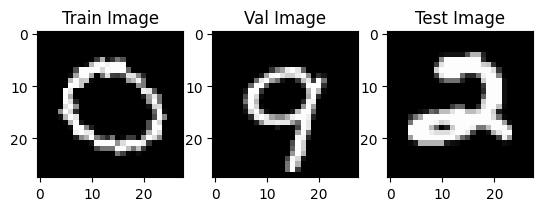

In [11]:
	
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [12]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

  2%|▏         | 1/50 [00:16<13:51, 16.97s/it]

------------------------------
Train Loss EPOCH 1: 2.3168
Valid Loss EPOCH 1: 2.2437
Train Accuracy EPOCH 1: 0.1416
Valid Accuracy EPOCH 1: 0.2367
------------------------------


  4%|▍         | 2/50 [00:33<13:25, 16.79s/it]

------------------------------
Train Loss EPOCH 2: 1.9082
Valid Loss EPOCH 2: 1.6625
Train Accuracy EPOCH 2: 0.3494
Valid Accuracy EPOCH 2: 0.4714
------------------------------


  6%|▌         | 3/50 [00:50<13:04, 16.69s/it]

------------------------------
Train Loss EPOCH 3: 1.5715
Valid Loss EPOCH 3: 1.4156
Train Accuracy EPOCH 3: 0.5063
Valid Accuracy EPOCH 3: 0.5921
------------------------------


  8%|▊         | 4/50 [01:06<12:48, 16.70s/it]

------------------------------
Train Loss EPOCH 4: 1.3861
Valid Loss EPOCH 4: 1.2439
Train Accuracy EPOCH 4: 0.5949
Valid Accuracy EPOCH 4: 0.6586
------------------------------


 10%|█         | 5/50 [01:23<12:31, 16.69s/it]

------------------------------
Train Loss EPOCH 5: 1.2621
Valid Loss EPOCH 5: 1.1723
Train Accuracy EPOCH 5: 0.6501
Valid Accuracy EPOCH 5: 0.6745
------------------------------


 12%|█▏        | 6/50 [01:40<12:16, 16.74s/it]

------------------------------
Train Loss EPOCH 6: 1.1587
Valid Loss EPOCH 6: 1.0556
Train Accuracy EPOCH 6: 0.6840
Valid Accuracy EPOCH 6: 0.7119
------------------------------


 14%|█▍        | 7/50 [01:57<11:58, 16.71s/it]

------------------------------
Train Loss EPOCH 7: 1.0684
Valid Loss EPOCH 7: 0.9528
Train Accuracy EPOCH 7: 0.7144
Valid Accuracy EPOCH 7: 0.7633
------------------------------


 16%|█▌        | 8/50 [02:13<11:43, 16.76s/it]

------------------------------
Train Loss EPOCH 8: 0.9903
Valid Loss EPOCH 8: 0.8752
Train Accuracy EPOCH 8: 0.7393
Valid Accuracy EPOCH 8: 0.7948
------------------------------


 18%|█▊        | 9/50 [02:31<11:38, 17.05s/it]

------------------------------
Train Loss EPOCH 9: 0.9338
Valid Loss EPOCH 9: 0.7967
Train Accuracy EPOCH 9: 0.7557
Valid Accuracy EPOCH 9: 0.8069
------------------------------


 20%|██        | 10/50 [02:48<11:19, 16.99s/it]

------------------------------
Train Loss EPOCH 10: 0.8635
Valid Loss EPOCH 10: 0.7614
Train Accuracy EPOCH 10: 0.7799
Valid Accuracy EPOCH 10: 0.8219
------------------------------


 22%|██▏       | 11/50 [03:06<11:10, 17.20s/it]

------------------------------
Train Loss EPOCH 11: 0.8164
Valid Loss EPOCH 11: 0.6965
Train Accuracy EPOCH 11: 0.7914
Valid Accuracy EPOCH 11: 0.8424
------------------------------


 24%|██▍       | 12/50 [03:24<11:05, 17.51s/it]

------------------------------
Train Loss EPOCH 12: 0.7656
Valid Loss EPOCH 12: 0.6470
Train Accuracy EPOCH 12: 0.8062
Valid Accuracy EPOCH 12: 0.8519
------------------------------


 26%|██▌       | 13/50 [03:42<10:53, 17.66s/it]

------------------------------
Train Loss EPOCH 13: 0.7322
Valid Loss EPOCH 13: 0.6653
Train Accuracy EPOCH 13: 0.8130
Valid Accuracy EPOCH 13: 0.8448
------------------------------


 28%|██▊       | 14/50 [04:00<10:37, 17.72s/it]

------------------------------
Train Loss EPOCH 14: 0.6981
Valid Loss EPOCH 14: 0.6354
Train Accuracy EPOCH 14: 0.8202
Valid Accuracy EPOCH 14: 0.8331
------------------------------


 30%|███       | 15/50 [04:18<10:24, 17.85s/it]

------------------------------
Train Loss EPOCH 15: 0.6538
Valid Loss EPOCH 15: 0.5421
Train Accuracy EPOCH 15: 0.8311
Valid Accuracy EPOCH 15: 0.8752
------------------------------


 32%|███▏      | 16/50 [04:36<10:09, 17.93s/it]

------------------------------
Train Loss EPOCH 16: 0.6246
Valid Loss EPOCH 16: 0.5133
Train Accuracy EPOCH 16: 0.8365
Valid Accuracy EPOCH 16: 0.8819
------------------------------


 34%|███▍      | 17/50 [04:55<10:02, 18.24s/it]

------------------------------
Train Loss EPOCH 17: 0.5889
Valid Loss EPOCH 17: 0.4916
Train Accuracy EPOCH 17: 0.8478
Valid Accuracy EPOCH 17: 0.8840
------------------------------


 36%|███▌      | 18/50 [05:12<09:34, 17.95s/it]

------------------------------
Train Loss EPOCH 18: 0.5698
Valid Loss EPOCH 18: 0.4978
Train Accuracy EPOCH 18: 0.8510
Valid Accuracy EPOCH 18: 0.8805
------------------------------


 38%|███▊      | 19/50 [05:29<09:07, 17.67s/it]

------------------------------
Train Loss EPOCH 19: 0.5462
Valid Loss EPOCH 19: 0.4609
Train Accuracy EPOCH 19: 0.8553
Valid Accuracy EPOCH 19: 0.8910
------------------------------


 40%|████      | 20/50 [05:46<08:41, 17.39s/it]

------------------------------
Train Loss EPOCH 20: 0.5149
Valid Loss EPOCH 20: 0.4406
Train Accuracy EPOCH 20: 0.8651
Valid Accuracy EPOCH 20: 0.8912
------------------------------


 42%|████▏     | 21/50 [06:03<08:18, 17.18s/it]

------------------------------
Train Loss EPOCH 21: 0.4920
Valid Loss EPOCH 21: 0.4336
Train Accuracy EPOCH 21: 0.8699
Valid Accuracy EPOCH 21: 0.8883
------------------------------


 44%|████▍     | 22/50 [06:19<07:57, 17.06s/it]

------------------------------
Train Loss EPOCH 22: 0.4781
Valid Loss EPOCH 22: 0.3814
Train Accuracy EPOCH 22: 0.8727
Valid Accuracy EPOCH 22: 0.9038
------------------------------


 46%|████▌     | 23/50 [06:36<07:38, 16.98s/it]

------------------------------
Train Loss EPOCH 23: 0.4503
Valid Loss EPOCH 23: 0.3870
Train Accuracy EPOCH 23: 0.8807
Valid Accuracy EPOCH 23: 0.9052
------------------------------


 48%|████▊     | 24/50 [06:53<07:19, 16.91s/it]

------------------------------
Train Loss EPOCH 24: 0.4370
Valid Loss EPOCH 24: 0.3537
Train Accuracy EPOCH 24: 0.8821
Valid Accuracy EPOCH 24: 0.9107
------------------------------


 50%|█████     | 25/50 [07:12<07:19, 17.60s/it]

------------------------------
Train Loss EPOCH 25: 0.4243
Valid Loss EPOCH 25: 0.3298
Train Accuracy EPOCH 25: 0.8861
Valid Accuracy EPOCH 25: 0.9190
------------------------------


 52%|█████▏    | 26/50 [07:29<06:58, 17.44s/it]

------------------------------
Train Loss EPOCH 26: 0.4106
Valid Loss EPOCH 26: 0.3320
Train Accuracy EPOCH 26: 0.8885
Valid Accuracy EPOCH 26: 0.9102
------------------------------


 54%|█████▍    | 27/50 [07:47<06:42, 17.48s/it]

------------------------------
Train Loss EPOCH 27: 0.3862
Valid Loss EPOCH 27: 0.3276
Train Accuracy EPOCH 27: 0.8941
Valid Accuracy EPOCH 27: 0.9162
------------------------------


 56%|█████▌    | 28/50 [08:05<06:30, 17.75s/it]

------------------------------
Train Loss EPOCH 28: 0.3919
Valid Loss EPOCH 28: 0.3155
Train Accuracy EPOCH 28: 0.8913
Valid Accuracy EPOCH 28: 0.9195
------------------------------


 58%|█████▊    | 29/50 [08:23<06:09, 17.61s/it]

------------------------------
Train Loss EPOCH 29: 0.3700
Valid Loss EPOCH 29: 0.2856
Train Accuracy EPOCH 29: 0.8981
Valid Accuracy EPOCH 29: 0.9243
------------------------------


 60%|██████    | 30/50 [08:40<05:50, 17.51s/it]

------------------------------
Train Loss EPOCH 30: 0.3520
Valid Loss EPOCH 30: 0.2858
Train Accuracy EPOCH 30: 0.9030
Valid Accuracy EPOCH 30: 0.9262
------------------------------


 62%|██████▏   | 31/50 [08:57<05:32, 17.50s/it]

------------------------------
Train Loss EPOCH 31: 0.3515
Valid Loss EPOCH 31: 0.2889
Train Accuracy EPOCH 31: 0.9031
Valid Accuracy EPOCH 31: 0.9236
------------------------------


 64%|██████▍   | 32/50 [09:15<05:15, 17.53s/it]

------------------------------
Train Loss EPOCH 32: 0.3448
Valid Loss EPOCH 32: 0.2518
Train Accuracy EPOCH 32: 0.9042
Valid Accuracy EPOCH 32: 0.9333
------------------------------


 66%|██████▌   | 33/50 [09:32<04:56, 17.43s/it]

------------------------------
Train Loss EPOCH 33: 0.3311
Valid Loss EPOCH 33: 0.2772
Train Accuracy EPOCH 33: 0.9067
Valid Accuracy EPOCH 33: 0.9274
------------------------------


 68%|██████▊   | 34/50 [09:50<04:39, 17.46s/it]

------------------------------
Train Loss EPOCH 34: 0.3164
Valid Loss EPOCH 34: 0.2548
Train Accuracy EPOCH 34: 0.9115
Valid Accuracy EPOCH 34: 0.9333
------------------------------


 70%|███████   | 35/50 [10:07<04:22, 17.49s/it]

------------------------------
Train Loss EPOCH 35: 0.3083
Valid Loss EPOCH 35: 0.2504
Train Accuracy EPOCH 35: 0.9142
Valid Accuracy EPOCH 35: 0.9336
------------------------------


 72%|███████▏  | 36/50 [10:25<04:05, 17.56s/it]

------------------------------
Train Loss EPOCH 36: 0.3108
Valid Loss EPOCH 36: 0.2553
Train Accuracy EPOCH 36: 0.9121
Valid Accuracy EPOCH 36: 0.9298
------------------------------


 74%|███████▍  | 37/50 [10:43<03:49, 17.64s/it]

------------------------------
Train Loss EPOCH 37: 0.3027
Valid Loss EPOCH 37: 0.2285
Train Accuracy EPOCH 37: 0.9134
Valid Accuracy EPOCH 37: 0.9374
------------------------------


 76%|███████▌  | 38/50 [11:00<03:30, 17.52s/it]

------------------------------
Train Loss EPOCH 38: 0.2915
Valid Loss EPOCH 38: 0.2239
Train Accuracy EPOCH 38: 0.9168
Valid Accuracy EPOCH 38: 0.9398
------------------------------


 78%|███████▊  | 39/50 [11:18<03:13, 17.55s/it]

------------------------------
Train Loss EPOCH 39: 0.2873
Valid Loss EPOCH 39: 0.2270
Train Accuracy EPOCH 39: 0.9172
Valid Accuracy EPOCH 39: 0.9364
------------------------------


 80%|████████  | 40/50 [11:35<02:54, 17.42s/it]

------------------------------
Train Loss EPOCH 40: 0.2971
Valid Loss EPOCH 40: 0.2264
Train Accuracy EPOCH 40: 0.9133
Valid Accuracy EPOCH 40: 0.9357
------------------------------


 82%|████████▏ | 41/50 [11:52<02:37, 17.48s/it]

------------------------------
Train Loss EPOCH 41: 0.2807
Valid Loss EPOCH 41: 0.2317
Train Accuracy EPOCH 41: 0.9189
Valid Accuracy EPOCH 41: 0.9326
------------------------------


 84%|████████▍ | 42/50 [12:11<02:21, 17.72s/it]

------------------------------
Train Loss EPOCH 42: 0.2727
Valid Loss EPOCH 42: 0.2342
Train Accuracy EPOCH 42: 0.9225
Valid Accuracy EPOCH 42: 0.9317
------------------------------


 86%|████████▌ | 43/50 [12:29<02:05, 17.89s/it]

------------------------------
Train Loss EPOCH 43: 0.2671
Valid Loss EPOCH 43: 0.2139
Train Accuracy EPOCH 43: 0.9236
Valid Accuracy EPOCH 43: 0.9424
------------------------------


 88%|████████▊ | 44/50 [12:47<01:47, 17.90s/it]

------------------------------
Train Loss EPOCH 44: 0.2615
Valid Loss EPOCH 44: 0.2017
Train Accuracy EPOCH 44: 0.9238
Valid Accuracy EPOCH 44: 0.9407
------------------------------


 90%|█████████ | 45/50 [13:05<01:30, 18.01s/it]

------------------------------
Train Loss EPOCH 45: 0.2570
Valid Loss EPOCH 45: 0.2015
Train Accuracy EPOCH 45: 0.9268
Valid Accuracy EPOCH 45: 0.9410
------------------------------


 92%|█████████▏| 46/50 [13:23<01:12, 18.12s/it]

------------------------------
Train Loss EPOCH 46: 0.2515
Valid Loss EPOCH 46: 0.2105
Train Accuracy EPOCH 46: 0.9266
Valid Accuracy EPOCH 46: 0.9405
------------------------------


 94%|█████████▍| 47/50 [13:42<00:54, 18.23s/it]

------------------------------
Train Loss EPOCH 47: 0.2503
Valid Loss EPOCH 47: 0.2051
Train Accuracy EPOCH 47: 0.9261
Valid Accuracy EPOCH 47: 0.9431
------------------------------


 96%|█████████▌| 48/50 [14:00<00:36, 18.28s/it]

------------------------------
Train Loss EPOCH 48: 0.2440
Valid Loss EPOCH 48: 0.1982
Train Accuracy EPOCH 48: 0.9292
Valid Accuracy EPOCH 48: 0.9438
------------------------------


 98%|█████████▊| 49/50 [14:18<00:18, 18.17s/it]

------------------------------
Train Loss EPOCH 49: 0.2399
Valid Loss EPOCH 49: 0.2027
Train Accuracy EPOCH 49: 0.9299
Valid Accuracy EPOCH 49: 0.9424
------------------------------


100%|██████████| 50/50 [14:36<00:00, 17.52s/it]


------------------------------
Train Loss EPOCH 50: 0.2350
Valid Loss EPOCH 50: 0.1892
Train Accuracy EPOCH 50: 0.9299
Valid Accuracy EPOCH 50: 0.9452
------------------------------
Training Time: 876.06s


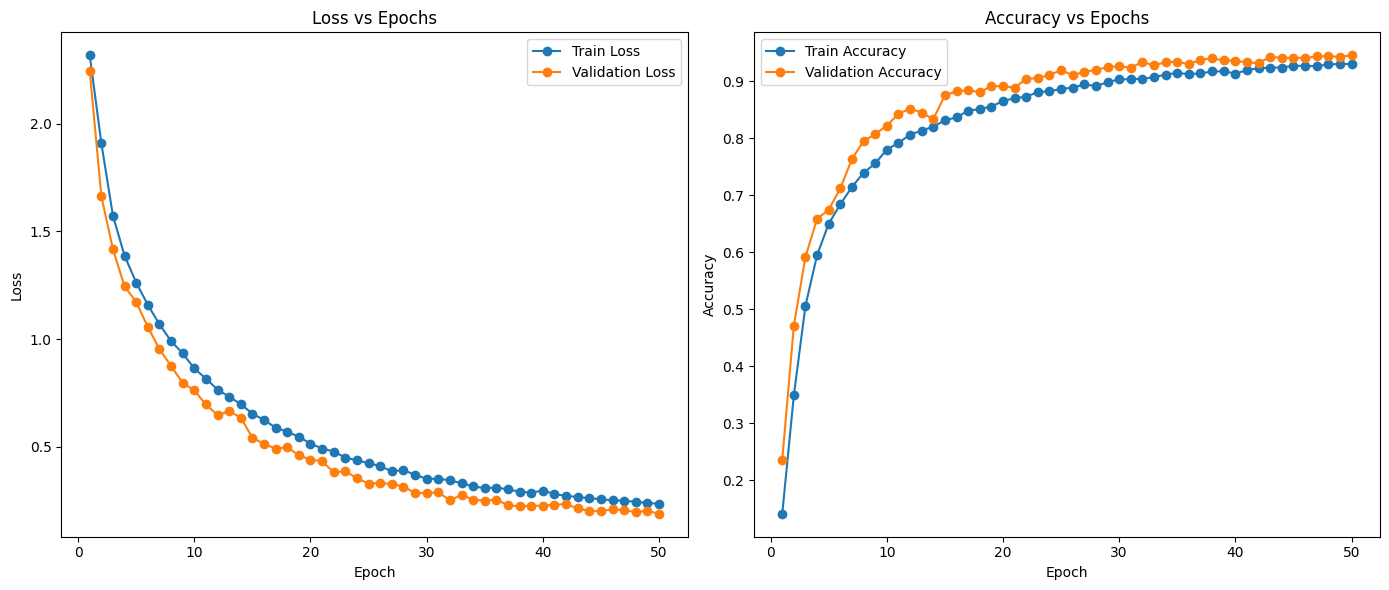

In [13]:
import timeit
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=adam_betas, lr=learning_rate, weight_decay=adam_weight_decay)

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start = timeit.default_timer()
for epoch in tqdm(range(epochs), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach().numpy())
        train_preds.extend(y_pred_label.cpu().detach().numpy())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach().numpy())
            val_preds.extend(y_pred_label.cpu().detach().numpy())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {train_accuracy:.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {val_accuracy:.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

# Plotting the loss and accuracy curves
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
torch.cuda.empty_cache()

In [15]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00,  9.60it/s]


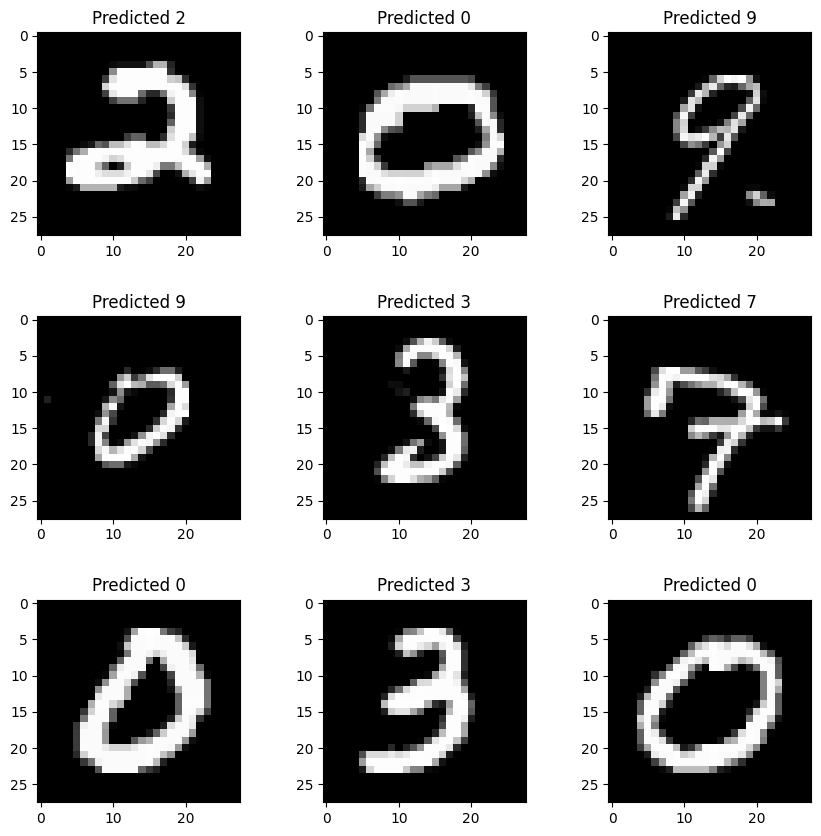

In [20]:
f, axarr = plt.subplots(3, 3, figsize=(10, 10))
counter = 0
for i in range(3):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("predicted.csv", index=False)
submission_df.head()